# SciPy Optimize
*Last updated by Arthur Ryman on  2022-05-21*

## Introduction

I have run into a problem in `RWC_alam()`. The SymPy solvers fails for certain values of parameters.
The solvers seek to find an exact solution but all we really need is a good approximation to the optimal
value of $a_0$.

The goal of this notebook is to determine of the SciPy `optimize()` function can find decent values.

## Simple Example

Recreate the simple example given in https://realpython.com/python-scipy-cluster-optimize/#using-the-optimize-module-in-scipy.

We can try `minimize_scalar()` and `root_scalar()`.

In [1]:
from scipy.optimize import minimize_scalar

def objective_function(x):
    return 3 * x ** 4 - 2 * x + 1

objective_function(0.55)

0.17451875000000006

In [2]:
import numpy as np
import pandas as pd

xs = np.arange(0, 1.01, 0.01)
x_index = pd.Index(xs, name='x')
df = pd.DataFrame(index=x_index)

In [3]:
df['y'] = [objective_function(x) for x in xs]

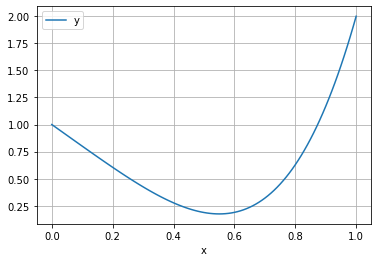

In [4]:
df.plot(grid=True);

In [5]:
res = minimize_scalar(objective_function)
res

     fun: 0.17451818777634331
 message: '\nOptimization terminated successfully;\nThe returned value satisfies the termination criteria\n(using xtol = 1.48e-08 )'
    nfev: 16
     nit: 12
 success: True
       x: 0.5503212087491959

## `RWC_alam()`

In this case we are trying to find optimal values of the parameters $a$ and $\lambda_v$
that minimize the expectation value $E$ of the RWC Hamiltonian defined by $(B, c_1, c_2)$
on the ground state defined by $(a, \lambda_v)$ where $\lambda_v$ is a function of $a$.

The paper WR2015 gives the following equations for the case $v = 0$.

In [6]:
from acmpy.papers.wr2015 import *

Eq_B16

Eq(E, B*c1*lambda0/(2*a**2) + B*c2*lambda0*(lambda0 + 1)/(2*a**4) + a**2*(1 + 9/(4*lambda0 - 4))/(2*B))

In [7]:
Eq_B11

Eq(lambda0, sqrt(a**4*beta0**4 + 9/4) + 1)

In [8]:
Eq_B15

Eq(beta0, Piecewise((sqrt(2)*sqrt(-c1/c2)/2, c1 < 0), (0, True)))

In [9]:
def make_E_a(B, c1, c2):
    beta0 = float(beta0_B15(c1, c2))
    def E_a(a):
        lambda0 = float(lambda0_B11(a, beta0))
        return float(E_B16(a, lambda0, B, c1, c2))
    return E_a

E_a_10 = make_E_a(10, -3, 2)
E_a_10(1)

58.39784678619764

In [10]:
a_index = pd.Index(np.arange(1.0, 10.1, 0.1), name='a')
E_df = pd.DataFrame(index=a_index)

In [11]:
E_df['B=10'] = [E_a_10(a) for a in a_index]

<AxesSubplot:xlabel='a'>

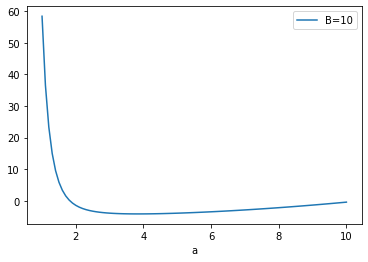

In [12]:
E_df.plot()

In [13]:
res_10 = minimize_scalar(E_a_10, bracket=(1, 10))
res_10

     fun: -4.124033118347146
 message: '\nOptimization terminated successfully;\nThe returned value satisfies the termination criteria\n(using xtol = 1.48e-08 )'
    nfev: 21
     nit: 17
 success: True
       x: 3.835914396554969

<AxesSubplot:xlabel='a'>

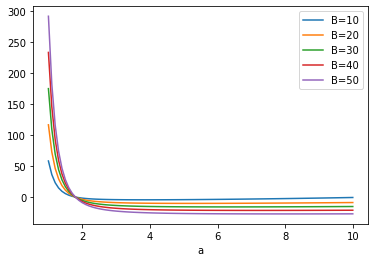

In [16]:
res_B = dict()
for B in range(20, 60, 10):
    name_B = f'B={B}'
    E_a_B = make_E_a(B, -3, 2)
    E_df[name_B] = [E_a_B(a) for a in a_index]
    res_B[B] = minimize_scalar(E_a_B, bracket=(1, 100))
E_df.plot()

In [17]:
for B in res_B:
    print('=' * 20)
    print(f'B={B}')
    print(res_B[B])

B=20
     fun: -9.885134142691431
 message: '\nOptimization terminated successfully;\nThe returned value satisfies the termination criteria\n(using xtol = 1.48e-08 )'
    nfev: 22
     nit: 18
 success: True
       x: -5.202970554521825
B=30
     fun: -15.556448068718904
 message: '\nOptimization terminated successfully;\nThe returned value satisfies the termination criteria\n(using xtol = 1.48e-08 )'
    nfev: 22
     nit: 18
 success: True
       x: 6.27313670563223
B=40
     fun: -21.204764227311554
 message: '\nOptimization terminated successfully;\nThe returned value satisfies the termination criteria\n(using xtol = 1.48e-08 )'
    nfev: 23
     nit: 19
 success: True
       x: 7.184399509043185
B=50
     fun: -26.84380093848864
 message: '\nOptimization terminated successfully;\nThe returned value satisfies the termination criteria\n(using xtol = 1.48e-08 )'
    nfev: 22
     nit: 18
 success: True
       x: 7.992004371274268


## Use $A = a^2$

The above looks promising but the behavior might improve if we optimize with respect to $A = a^2$.

In [24]:
A_index = pd.Index(np.arange(1, 10.1, 0.1), name='A')
E_A_df = pd.DataFrame(index=A_index)

In [25]:
import math
def make_E_A(B, c1, c2):
    beta0 = float(beta0_B15(c1, c2))
    def E_A(A):
        a = math.sqrt(A)
        lambda0 = float(lambda0_B11(a, beta0))
        return float(E_B16(a, lambda0, B, c1, c2))
    return E_A

<AxesSubplot:xlabel='A'>

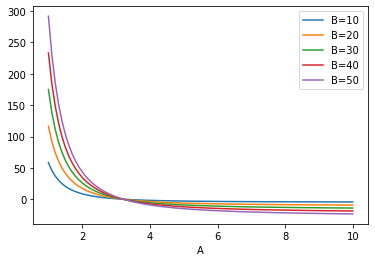

In [27]:
res_A_B = dict()
for B in range(10, 60, 10):
    name_B = f'B={B}'
    E_A_B = make_E_A(B, -3, 2)
    E_A_df[name_B] = [E_A_B(A) for A in A_index]
    res_A_B[B] = minimize_scalar(E_A_B, bracket=(1, 10))
E_A_df.plot()

In [28]:
for B in res_A_B:
    print('=' * 20)
    print(f'B={B}')
    print(res_A_B[B])

B=10
     fun: -4.124033118347147
 message: '\nOptimization terminated successfully;\nThe returned value satisfies the termination criteria\n(using xtol = 1.48e-08 )'
    nfev: 17
     nit: 13
 success: True
       x: 14.714238242291719
B=20
     fun: -9.885134142691431
 message: '\nOptimization terminated successfully;\nThe returned value satisfies the termination criteria\n(using xtol = 1.48e-08 )'
    nfev: 22
     nit: 16
 success: True
       x: 27.070903137123604
B=30
     fun: -15.556448068718897
 message: '\nOptimization terminated successfully;\nThe returned value satisfies the termination criteria\n(using xtol = 1.48e-08 )'
    nfev: 20
     nit: 13
 success: True
       x: 39.35224839442481
B=40
     fun: -21.204764227311564
 message: '\nOptimization terminated successfully;\nThe returned value satisfies the termination criteria\n(using xtol = 1.48e-08 )'
    nfev: 21
     nit: 13
 success: True
       x: 51.615594870767886
B=50
     fun: -26.843800938488656
 message: '\nOpt